## Theoretical Uncertainty of Azimuth Offset Stack from Sentinel-1

In [2]:
%matplotlib inline
import os
import time
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
from mintpy.utils import plot as pp, network as pnet, ptime
from mintpy.objects import ifgramStack, timeseries

### Ratio of azimuth resolution to half of the wavelength

OR radar frequency to azimuth bandwidth ratio (accuracy of interferometry to correlation)

Reference: https://github.com/insarlab/MintPy-tutorial/blob/master/applications/calculate_multilook_number.ipynb

In [6]:
speed_of_light = 299792458    #m/s

# Sentinel-1 parameter
f0 = 5.405e9       #Hz
wvl = speed_of_light / f0   #0.055 m
az_spacing = 14.1  #m
rg_spacing = 4.7   #m
print('ratio of azimuth resolution to half of wavelength: {:.0f}'.format(az_spacing / (wvl * 0.5)))

ratio of azimuth resolution to half of wavelength: 508


In [7]:
## displacement STD in azimuth direction from complex cross correlation (Bamler and Einder, 2005)
gamma = 0.8
#N = np.linspace(100,40000,100)
N = 256 * 256
sigma0 = (3 / (2*N)) ** 0.5 * (1 - gamma**2) ** 0.5 / (np.pi * gamma) * az_spacing
print('offset STD for single offset: {:.1f} cm'.format(sigma0 * 100 * np.sqrt(2)))

offset STD for single offset: 2.3 cm


In [8]:
# list of acquisition dates
num_image = 100
revisit_time = 12   #days
time0 = dt.datetime(2015,1,1,0,0,0)
times = []
for i in range(num_image):
    times.append(time0 + dt.timedelta(days=revisit_time*i))
date_list = [i.strftime("%Y%m%d") for i in times]
tbase = np.array(ptime.date_list2tbase(date_list)[0]) / 365.25

# list of offset pairs
date12_list = pnet.select_pairs_sequential(date_list, num_connection=3, date12_format='YYYYMMDD_YYYYMMDD')
cov_off = np.diag(np.ones(len(date12_list))) * (sigma0**2)
tbase12 = []
for date12 in date12_list:
    time1, time2 = [dt.datetime(*time.strptime(i, "%Y%m%d")[0:5]) for i in date12.split('_')]
    tbase12.append((time2 - time1).days / 365.25)

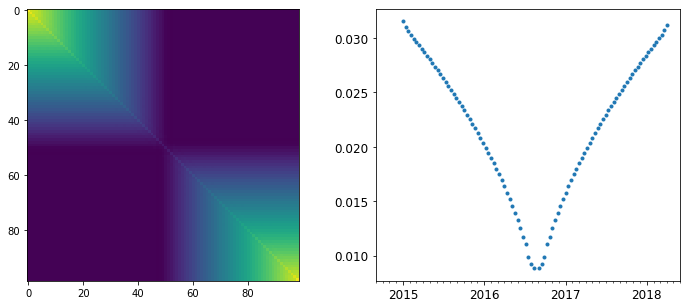

average velocity STD: 1.3 cm/yr


In [9]:
## method 1: stack --> time-series --> velocity
ref_ind = int(num_image/2)
A = ifgramStack.get_design_matrix4timeseries(date12_list, refDate=date_list[ref_ind])[0]
cov_ts = np.linalg.inv(A.T.dot(np.linalg.inv(cov_off)).dot(A))
#cov_ts0 = np.diag(cov_ts0)
#cov_ts = np.diag(np.concatenate((cov_ts0[0:ref_ind], np.array([0]), cov_ts0[ref_ind:])))
#cov_ts = np.zeros((num_image, num_image), dtype=np.float32)
#cov_ts[0:ref_ind  , 0:ref_ind]  = cov_ts0[0:ref_ind, 0:ref_ind]
#cov_ts[0:ref_ind  , ref_ind+1:] = cov_ts0[0:ref_ind, ref_ind:]
#cov_ts[ref_ind+1: , 0:ref_ind]  = cov_ts0[ref_ind: , 0:ref_ind]
#cov_ts[ref_ind+1: , ref_ind+1:] = cov_ts0[ref_ind: , ref_ind:]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[12,5])
axs[0].imshow(cov_ts)
axs[1].plot(times[0:ref_ind] + times[ref_ind+1:], np.sqrt(np.diag(cov_ts)), '.')
pp.auto_adjust_xaxis_date(axs[1], times)
plt.show()

## time-series to velocity
B = timeseries.get_design_matrix4average_velocity(date_list, refDate=date_list[ref_ind])
B = np.concatenate((B[0:ref_ind], B[ref_ind+1:]))
B = B[:,0].reshape(-1,1)
cov_vel = np.linalg.inv(B.T.dot(np.linalg.inv(cov_ts)).dot(B))
std_vel = np.sqrt(cov_vel[0,0])
print('average velocity STD: {:.1f} cm/yr'.format(std_vel*100))

In [10]:
## Method 2: stack --> velocity
A = np.array(tbase12).reshape(-1,1)
cov_vel = np.linalg.inv(A.T.dot(np.linalg.inv(cov_off)).dot(A))
std_vel = np.sqrt(cov_vel[0,0])
print('average velocity STD: {:.1f} cm/yr'.format(std_vel*100*np.sqrt(2)))

average velocity STD: 1.9 cm/yr
